# Visualize Code Generation Results - Reflection Results

1. 15 small language models (SLMs) were tested on 4 code generation datasets.
2. Metric used - Pass@1
3. This notebooks load raw results, visualizes them by dataset, and ranks the models based on their average performance.
4. Alternatively, it applies the MinMaxScaler to normalize the results and then rank SLMs.

__Candiates for removal__ for the reflection workflow cycle:
* Mistral 7B (lowest results)
* Mistral codestral_mamba - discontinued by Mistral AI because API call to list all the available models doesn't contain this one, only the 22B codstral model and the codestral embeddings model.
* Solar-10.7B (10.7B model, but low results).
* Phixtral-4x2_8 (duplicates the results of Phixtral-2x2_8).
* Mistral Nemo (12B model - largest among all, but it performs at the level of 7~8B models). SINCE CODESTRAL_MAMBA IS DISCONTINUED, I MIGHT AS WELL KEEP NEMO

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

# PART 1. Load Results and Scale the Four Datasets

In [3]:
# load all data
file = '/Users/andrew/Documents/04_git/code-generation/0_documents/2_docs/indiv_model_results_multiagent_20250529.xlsx'
sheet_names = ['HumanEval_Multiagent', 'BigCode_Multiagent', 'MBPP_Multiagent', 'LBPP_Multiagent',]
res_raw = dict()
for sheet_name in sheet_names:
    res_raw[sheet_name] = pd.read_excel( file, sheet_name=sheet_name )
print('Datasets:', ', '.join(list(res_raw.keys())))
print(res_raw['HumanEval_Multiagent'].shape)
res_raw['HumanEval_Multiagent']

Datasets: HumanEval_Multiagent, BigCode_Multiagent, MBPP_Multiagent, LBPP_Multiagent
(12, 17)


,#,dataset,prompt,cleaning,temperature,top_p,phixtral-2x2_8,Llama-3.1-8B,Codegemma-7b-it,deepseek-coder-6.7b,OpenCodeInterpreter-DS-6.7B,Artigenz-Coder-DS-6.7B,CodeQwen1.5-7B-Chat,Nxcode-CQ-7B-orpo,mistral_3b,mistral_8B,mistral_nemo
0,1,mbpp_multiagent,basic_prompt,raw,1,1,0.137023,0.000000,0.000000,0.115771,0.355739,0.477700,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,mbpp_multiagent,basic_prompt,partial,1,1,0.306637,0.500263,0.556300,0.728983,0.718940,0.747930,0.824976,0.831185,0.777178,0.789516,0.707213
2,3,mbpp_multiagent,basic_prompt,full,1,1,0.320610,0.529960,0.566022,0.717963,0.721575,0.766330,0.830621,0.841923,0.750128,0.775775,0.694817
3,4,mbpp_multiagent,basic_prompt,full_light,1,1,0.308592,0.518358,0.657595,0.730071,0.726546,0.740405,0.821596,0.853794,0.766396,0.789918,0.699731
4,5,mbpp_multiagent,prompt,raw,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.165083,0.000000,0.000000,0.000000,0.000000,0.000000
5,6,mbpp_multiagent,prompt,partial,1,1,0.564858,0.589924,0.499325,0.801824,0.745208,0.718567,0.797662,0.806479,0.135307,0.717619,0.641637
6,7,mbpp_multiagent,prompt,full,1,1,0.576783,0.723757,0.519952,0.786573,0.740312,0.731743,0.847963,0.841174,0.773479,0.811447,0.657737
7,8,mbpp_multiagent,prompt,full_light,1,1,0.591852,0.736150,0.517160,0.832627,0.755843,0.796775,0.846173,0.835203,0.763383,0.806471,0.648387
8,9,mbpp_multiagent,full_prompt,raw,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.183131,0.000000,0.000000,0.000000,0.000000,0.000000
9,10,mbpp_multiagent,full_prompt,partial,1,1,0.545911,0.557462,0.554936,0.702337,0.785596,0.720021,0.847156,0.834514,0.226739,0.706600,0.510429


In [4]:
# select 15 SLM model columns and add index for convenience
res_raw_short = dict()
for key in res_raw:
    df = res_raw[key]
    param_cols = ['#', 'dataset', 'prompt', 'cleaning', 'temperature', 'top_p']
    score_cols = [c for c in df.columns if c not in param_cols]
    res_raw_short[key] = df[score_cols].apply(pd.to_numeric, errors='coerce')

    # Rebuild MultiIndex on rows from the original prompt/cleaning columns
    mi = pd.MultiIndex.from_frame(df[['prompt','cleaning']])
    res_raw_short[key].index = mi
    res_raw_short[key].index.names = ['prompt','cleaning']
print('Datasets:', ', '.join(list(res_raw_short.keys())))
print(res_raw_short['HumanEval_Multiagent'].shape)
res_raw_short['HumanEval_Multiagent']

Datasets: HumanEval_Multiagent, BigCode_Multiagent, MBPP_Multiagent, LBPP_Multiagent
(12, 11)


phixtral-2x2_8  Llama-3.1-8B  Codegemma-7b-it  \
prompt       cleaning                                                    
basic_prompt raw               0.137023      0.000000         0.000000   
             partial           0.306637      0.500263         0.556300   
             full              0.320610      0.529960         0.566022   
             full_light        0.308592      0.518358         0.657595   
prompt       raw               0.000000      0.000000         0.000000   
             partial           0.564858      0.589924         0.499325   
             full              0.576783      0.723757         0.519952   
             full_light        0.591852      0.736150         0.517160   
full_prompt  raw               0.000000      0.000000         0.000000   
             partial           0.545911      0.557462         0.554936   
             full              0.556490      0.576000         0.565745   
             full_light        0.547801      0.573502         0.545323   

                         deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  \
prompt       cleaning                                                       
basic_prompt raw                    0.115771                     0.355739   
             partial                0.728983                     0.718940   
             full                   0.717963                     0.721575   
             full_light             0.730071                     0.726546   
prompt       raw                    0.000000                     0.000000   
             partial                0.801824                     0.745208   
             full                   0.786573                     0.740312   
             full_light             0.832627                     0.755843   
full_prompt  raw                    0.000000                     0.000000   
             partial                0.702337                     0.785596   
             full                   0.721944                     0.747660   
             full_light             0.701402                     0.746167   

                         Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  \
prompt       cleaning                                                  
basic_prompt raw                       0.477700             0.000000   
             partial                   0.747930             0.824976   
             full                      0.766330             0.830621   
             full_light                0.740405             0.821596   
prompt       raw                       0.165083             0.000000   
             partial                   0.718567             0.797662   
             full                      0.731743             0.847963   
             full_light                0.796775             0.846173   
full_prompt  raw                       0.183131             0.000000   
             partial                   0.720021             0.847156   
             full                      0.710077             0.840086   
             full_light                0.725451             0.846793   

                         Nxcode-CQ-7B-orpo  mistral_3b  mistral_8B  \
prompt       cleaning                                                
basic_prompt raw                  0.000000    0.000000    0.000000   
             partial              0.831185    0.777178    0.789516   
             full                 0.841923    0.750128    0.775775   
             full_light           0.853794    0.766396    0.789918   
prompt       raw                  0.000000    0.000000    0.000000   
             partial              0.806479    0.135307    0.717619   
             full                 0.841174    0.773479    0.811447   
             full_light           0.835203    0.763383    0.806471   
full_prompt  raw                  0.000000    0.000000    0.000000   
             partial              0.834514    0.226739    0.706600   
             full                 0.834427    0.756020    0.

In [5]:
for key, df in res_raw_short.items():
    print(key)
    max_val = df.max().max()
    
    # Find row and column of the max value
    full_idx = (df == max_val).stack().idxmax()

    print(f'Max: {max_val:.4f}')
    print(full_idx)

    # get mean value for 'full' and 'full_light' rows
    filtered = pd.concat([
    df.xs('full', level='cleaning', drop_level=False),
    df.xs('full_light', level='cleaning', drop_level=False)
    ])
    row_means = filtered.mean(axis=1)
    overall_mean = row_means.mean()
    print(f"Mean of row-wise means for 'full' and 'full_light': {overall_mean:.4f}\n")

HumanEval_Multiagent
Max: 0.8538
('basic_prompt', 'full_light', 'Nxcode-CQ-7B-orpo')
Mean of row-wise means for 'full' and 'full_light': 0.7036

BigCode_Multiagent
Max: 0.3637
('basic_prompt', 'partial', 'mistral_8B')
Mean of row-wise means for 'full' and 'full_light': 0.3187

MBPP_Multiagent
Max: 0.7579
('basic_prompt', 'partial', 'CodeQwen1.5-7B-Chat')
Mean of row-wise means for 'full' and 'full_light': 0.5906

LBPP_Multiagent
Max: 0.3354
('basic_prompt', 'full_light', 'OpenCodeInterpreter-DS-6.7B')
Mean of row-wise means for 'full' and 'full_light': 0.2481



In [7]:
# scale scores in each dataframe
res = dict()
for key, df in res_raw_short.items():
    scaled_df = (df - df.min().min()) / (df.max().max() - df.min().min())
    res[key] = scaled_df
print('Datasets:', ', '.join(list(res.keys())))
print(res['HumanEval_Multiagent'].shape)
res['HumanEval_Multiagent']

Datasets: HumanEval_Multiagent, BigCode_Multiagent, MBPP_Multiagent, LBPP_Multiagent
(12, 11)


phixtral-2x2_8  Llama-3.1-8B  Codegemma-7b-it  \
prompt       cleaning                                                    
basic_prompt raw               0.160487      0.000000         0.000000   
             partial           0.359146      0.585929         0.651562   
             full              0.375512      0.620711         0.662949   
             full_light        0.361436      0.607122         0.770203   
prompt       raw               0.000000      0.000000         0.000000   
             partial           0.661586      0.690944         0.584831   
             full              0.675552      0.847695         0.608990   
             full_light        0.693202      0.862210         0.605719   
full_prompt  raw               0.000000      0.000000         0.000000   
             partial           0.639394      0.652923         0.649964   
             full              0.651784      0.674636         0.662625   
             full_light        0.641607      0.671710         0.638706   

                         deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  \
prompt       cleaning                                                       
basic_prompt raw                    0.135596                     0.416657   
             partial                0.853816                     0.842053   
             full                   0.840908                     0.845139   
             full_light             0.855090                     0.850961   
prompt       raw                    0.000000                     0.000000   
             partial                0.939131                     0.872819   
             full                   0.921267                     0.867085   
             full_light             0.975208                     0.885275   
full_prompt  raw                    0.000000                     0.000000   
             partial                0.822607                     0.920123   
             full                   0.845571                     0.875691   
             full_light             0.821512                     0.873942   

                         Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  \
prompt       cleaning                                                  
basic_prompt raw                       0.559503             0.000000   
             partial                   0.876007             0.966246   
             full                      0.897558             0.972858   
             full_light                0.867194             0.962288   
prompt       raw                       0.193352             0.000000   
             partial                   0.841616             0.934255   
             full                      0.857049             0.993170   
             full_light                0.933216             0.991073   
full_prompt  raw                       0.214490             0.000000   
             partial                   0.843318             0.992225   
             full                      0.831672             0.983944   
             full_light                0.849679             0.991799   

                         Nxcode-CQ-7B-orpo  mistral_3b  mistral_8B  \
prompt       cleaning                                                
basic_prompt raw                  0.000000    0.000000    0.000000   
             partial              0.973519    0.910264    0.924715   
             full                 0.986096    0.878582    0.908621   
             full_light           1.000000    0.897636    0.925186   
prompt       raw                  0.000000    0.000000    0.000000   
             partial              0.944582    0.158477    0.840505   
             full                 0.985219    0.905931    0.950401   
             full_light           0.978225    0.894107    0.944573   
full_prompt  raw                  0.000000    0.000000    0.000000   
             partial              0.977419    0.265567    0.827600   
             full                 0.977316    0.885482    0.

# PART 2. Select Best Cleaning Method, Best Prompting Strategy, and Rank SLMs Using Mean Values

## 2.1 Select the best cleaning method

### 2.1.1 Approach 1

In [8]:
# get mean values for each cleaning method and compare them with raw - the method with the largest diff wins
for key in res:
    df = res[key].copy()
    mean_scores = df.mean(axis=1).unstack(level=1)
    mean_scores.loc['mean'] = mean_scores.mean()
    max_col = mean_scores.loc['mean'].idxmax()
    print(f'Dataset: {key}\n')
    print(f"Cleaning method with the highest mean score: {max_col}")
    
    # Difference with raw
    full_value = mean_scores.loc['mean', 'full']
    full_light = mean_scores.loc['mean', 'full_light']
    raw_value  = mean_scores.loc['mean', 'raw']
    print(f"Difference between full and raw:       {full_value - raw_value:.5f}")
    print(f"Difference between full_light and raw: {full_light - raw_value:.5f}")
    print(f"Overall difference:                    {(full_value - raw_value)-(full_light-raw_value):.5f}\n")
    print(mean_scores)
    print('\n', '='*77, '\n', sep='')

Dataset: HumanEval_Multiagent

Cleaning method with the highest mean score: full_light
Difference between full and raw:       0.77020
Difference between full_light and raw: 0.77620
Overall difference:                    -0.00600

cleaning          full  full_light   partial       raw
prompt                                                
basic_prompt  0.800248    0.810606  0.797416  0.115658
full_prompt   0.810100    0.805062  0.744452  0.019499
prompt        0.852975    0.865657  0.747296  0.017577
mean          0.821108    0.827108  0.763055  0.050912


Dataset: BigCode_Multiagent

Cleaning method with the highest mean score: full
Difference between full and raw:       0.84822
Difference between full_light and raw: 0.81340
Overall difference:                    0.03482

cleaning          full  full_light   partial       raw
prompt                                                
basic_prompt  0.882531    0.845986  0.824644  0.117296
full_prompt   0.898016    0.888169  0.860890  0.0064

In [38]:
full = (0.77129+0.77676+0.77676+0.74459)
full_light = (0.77107+0.77520+0.77520+0.77798)
print(f'Full cleaning:       {full}\nFull light cleaning: {full_light}')

Full cleaning:       3.0694
Full light cleaning: 3.09945


__The full_light cleaning method wins__ because it has the largest overall difference with the raw cleaning results across all the prompts and all the datasets, althought the two methods are really close to each other in terms of the results.

In [39]:
Cleaning method with the highest mean score: full
Difference between full and raw:       0.77129
Difference between full_light and raw: 0.77107

Difference between full and raw:       0.77676
Difference between full_light and raw: 0.77520

Difference between full and raw:       0.77676
Difference between full_light and raw: 0.77520

Difference between full and raw:       0.74459
Difference between full_light and raw: 0.77798


SyntaxError: invalid syntax (1168574295.py, line 1)

### 2.1.2 Approach 2

In [9]:
# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Average across prompts for each (dataset, cleaning, model)
avg_across_prompts = combined.groupby(['dataset', 'cleaning']).mean()

# Step 2: Average across datasets for each (cleaning, model)
avg_across_all = avg_across_prompts.groupby('cleaning').mean()

# Step 3: Transpose to get models as rows
final_df = avg_across_all.T

# Step 4: sort columns if needed
cleaning_order = ['raw', 'partial', 'full', 'full_light']
final_df = final_df[cleaning_order]
final_df['best_cleaning'] = final_df.idxmax(axis=1)
final_df['best_cleaning2'] = final_df[cleaning_order].idxmax(axis=1).map({name: i for i, name in enumerate(cleaning_order)})
final_df = final_df.sort_values(by='full')
final_df.loc['mean'] = final_df.mean(numeric_only=True)

print(final_df['best_cleaning'].value_counts())
final_df

best_cleaning
full_light    7
full          4
Name: count, dtype: int64


cleaning,raw,partial,full,full_light,best_cleaning,best_cleaning2
phixtral-2x2_8,0.043187,0.576827,0.619541,0.618950,full,2.000000
Codegemma-7b-it,0.000000,0.674031,0.691405,0.711593,full_light,3.000000
mistral_nemo,0.000000,0.720680,0.739755,0.735959,full,2.000000
Llama-3.1-8B,0.000000,0.728015,0.761384,0.761482,full_light,3.000000
mistral_3b,0.000000,0.481421,0.785547,0.817272,full_light,3.000000
deepseek-coder-6.7b,0.016848,0.812178,0.818114,0.825716,full_light,3.000000
mistral_8B,0.000000,0.843302,0.842395,0.848018,full_light,3.000000
Artigenz-Coder-DS-6.7B,0.157170,0.851765,0.861328,0.865979,full_light,3.000000
OpenCodeInterpreter-DS-6.7B,0.071937,0.855445,0.871064,0.864908,full,2.000000
Nxcode-CQ-7B-orpo,0.000000,0.892553,0.919058,0.923813,full_light,3.000000


__The full_light cleaning method wins again__, this time in a more evident way. BOTH APPROACHES RESULT IN THE FULL_LIGHT CLEANING METHOD BEING THE WINNER.

In [34]:
# sanity check - view all intermediate dataframes used above
avg_across_prompts.head(25)

phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  Llama-3.1-8B  \
dataset cleaning                                                                
ds1     full              0.958333        0.958333     0.968468      0.931034   
        full_light        0.954545        0.954545     0.968468      0.922414   
        partial           0.712121        0.712121     0.914414      0.916667   
        raw               0.310606        0.310606     0.040541      0.000000   
ds2     full              0.879902        0.882353     0.941315      0.875556   
        full_light        0.750000        0.752451     0.938967      0.813333   
        partial           0.495098        0.492647     0.960094      0.804444   
        raw               0.154412        0.154412     0.077465      0.002222   
ds3     full              0.974565        0.974565     0.949405      0.973684   
        full_light        0.973226        0.973226     0.949405      0.970395   
        partial           0.965194        0.965194     0.947917      0.934211   
        raw               0.001339        0.001339     0.008929      0.010965   
ds4     full              0.896552        0.896552     0.894737      0.819444   
        full_light        0.931034        0.931034     0.894737      0.881944   
        partial           0.908046        0.908046     0.578947      0.833333   
        raw               0.057471        0.057471     0.052632      0.000000   

                    Codegemma-7b-it  deepseek-coder-6.7b  \
dataset cleaning                                           
ds1     full               0.950000             0.945274   
        full_light         0.950000             0.950249   
        partial            0.916667             0.950249   
        raw                0.000000             0.325871   
ds2     full               0.940898             0.957494   
        full_light         0.940898             0.897092   
        partial            0.959811             0.715884   
        raw                0.000000             0.102908   
ds3     full               0.996255             0.977226   
        full_light         0.996255             0.972050   
        partial            0.996255             0.972050   
        raw                0.000000             0.000000   
ds4     full               0.916667             0.991228   
        full_light         0.925926             0.991228   
        partial            0.777778             0.973684   
        raw                0.000000             0.000000   

                    OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
dataset cleaning                                                          
ds1     full                           0.973545                0.794872   
        full_light                     0.976190                0.820513   
        partial                        0.973545                0.794872   
        raw                            0.325397                0.538462   
ds2     full                           0.864368                0.932836   
        full_light                     0.825287                0.883085   
        partial                        0.747126                0.873134   
        raw                            0.154023                0.348259   
ds3     full                           0.994775                0.966049   
        full_light                     0.994775                0.966049   
        partial                        0.994775                0.965021   
        raw                            0.056426                0.003086   
ds4     full                           0.920290                0.944444   
        full_light                     0.927536                0.951389   
        partial                        0.927536                0.951389   
        raw                            0.007246                0.000000   

                    CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
dataset cleaning                                       

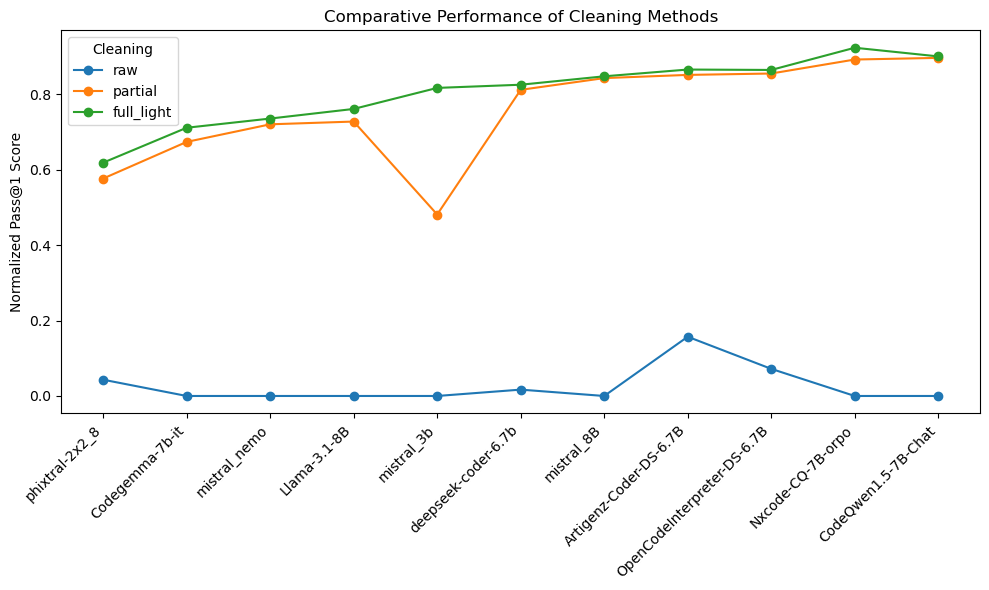

In [10]:
# visualize cleaning method performance
plot_df = final_df.drop(index='mean')
sorted_models = plot_df.index 
plt.figure(figsize=(10, 6))
for col in ['raw', 'partial', 'full_light']:
    y = plot_df[col]
    plt.plot(range(len(sorted_models)), y, marker='o', label=col)
plt.title('Comparative Performance of Cleaning Methods')
plt.xticks(range(len(sorted_models)), labels=sorted_models, rotation=45, ha='right')
plt.ylabel('Normalized Pass@1 Score')
plt.legend(title='Cleaning')
plt.tight_layout()
plt.show()

## 2.2 Select the best prompting strategy

In [11]:
# SELECT THE BEST PROMPTING STRATEGY

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter combined by the best cleaning method == 'full'
full_cleaned = combined.xs('full_light', level='cleaning')

# Step 2: Average across datasets for each prompt and model
avg_by_prompt = full_cleaned.groupby('prompt').mean()

# Step 3: Transpose so rows = models, columns = prompts
final_prompt_df = avg_by_prompt.T

# Step 4: Reorder prompt columns if needed
prompt_order    = ['basic_prompt', 'prompt', 'full_prompt']
final_prompt_df = final_prompt_df[prompt_order]
final_prompt_df['best_prompt'] = final_prompt_df.idxmax(axis=1)
final_prompt_df['best_prompt2'] = final_prompt_df[prompt_order].idxmax(axis=1).map({name: i for i, name in enumerate(prompt_order)})
final_prompt_df = final_prompt_df.sort_values(by='basic_prompt')
final_prompt_df.loc['mean']       = final_prompt_df.mean(numeric_only=True)

print(final_prompt_df['best_prompt'].value_counts())
final_prompt_df

best_prompt
basic_prompt    6
full_prompt     3
prompt          2
Name: count, dtype: int64


prompt,basic_prompt,prompt,full_prompt,best_prompt,best_prompt2
phixtral-2x2_8,0.474562,0.739030,0.643258,prompt,1.000000
Llama-3.1-8B,0.708833,0.771755,0.803858,full_prompt,2.000000
Codegemma-7b-it,0.712570,0.681873,0.740337,full_prompt,2.000000
mistral_nemo,0.818019,0.727014,0.662844,basic_prompt,0.000000
mistral_3b,0.856588,0.806787,0.788441,basic_prompt,0.000000
deepseek-coder-6.7b,0.867736,0.811286,0.798127,basic_prompt,0.000000
OpenCodeInterpreter-DS-6.7B,0.871515,0.860911,0.862299,basic_prompt,0.000000
Artigenz-Coder-DS-6.7B,0.882640,0.842910,0.872389,basic_prompt,0.000000
mistral_8B,0.894619,0.840382,0.809054,basic_prompt,0.000000
CodeQwen1.5-7B-Chat,0.899960,0.897347,0.905173,full_prompt,2.000000


In [12]:
# SAME CODE AS IN THE PREVIOUS CELL, BUT CURTAILED TO RANK THE MODEL BY AVERAGE ACROSS ALL PROMPTS

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter combined by the best cleaning method == 'full'
full_cleaned = combined.xs('full_light', level='cleaning')

# Step 2: Average across datasets for each prompt and model
avg_by_prompt = full_cleaned.groupby('prompt').mean()

# Step 3: Transpose so rows = models, columns = prompts
final_prompt_df = avg_by_prompt.T

# Step 4: Reorder prompt columns if needed
prompt_order    = ['basic_prompt', 'prompt', 'full_prompt']
final_prompt_df = final_prompt_df[prompt_order]

final_prompt_df['mean'] = final_prompt_df.mean(axis=1)
final_prompt_df = final_prompt_df.sort_values(by='mean', ascending=False)

final_prompt_df

prompt,basic_prompt,prompt,full_prompt,mean
Nxcode-CQ-7B-orpo,0.925725,0.945915,0.899799,0.923813
CodeQwen1.5-7B-Chat,0.899960,0.897347,0.905173,0.900826
Artigenz-Coder-DS-6.7B,0.882640,0.842910,0.872389,0.865979
OpenCodeInterpreter-DS-6.7B,0.871515,0.860911,0.862299,0.864908
mistral_8B,0.894619,0.840382,0.809054,0.848018
deepseek-coder-6.7b,0.867736,0.811286,0.798127,0.825716
mistral_3b,0.856588,0.806787,0.788441,0.817272
Llama-3.1-8B,0.708833,0.771755,0.803858,0.761482
mistral_nemo,0.818019,0.727014,0.662844,0.735959
Codegemma-7b-it,0.712570,0.681873,0.740337,0.711593


In [13]:
combined.head(25)

phixtral-2x2_8  Llama-3.1-8B  \
dataset              prompt       cleaning                                   
HumanEval_Multiagent basic_prompt raw               0.160487      0.000000   
                                  partial           0.359146      0.585929   
                                  full              0.375512      0.620711   
                                  full_light        0.361436      0.607122   
                     prompt       raw               0.000000      0.000000   
                                  partial           0.661586      0.690944   
                                  full              0.675552      0.847695   
                                  full_light        0.693202      0.862210   
                     full_prompt  raw               0.000000      0.000000   
                                  partial           0.639394      0.652923   
                                  full              0.651784      0.674636   
                                  full_light        0.641607      0.671710   
BigCode_Multiagent   basic_prompt raw               0.199731      0.000000   
                                  partial           0.345657      0.760411   
                                  full              0.616098      0.860975   
                                  full_light        0.443669      0.803428   
                     prompt       raw               0.015544      0.000000   
                                  partial           0.870463      0.664308   
                                  full              0.869496      0.830664   
                                  full_light        0.909620      0.691051   
                     full_prompt  raw               0.024983      0.000000   
                                  partial           0.724849      0.956666   
                                  full              0.870374      0.938487   
                                  full_light        0.777152      0.940187   
MBPP_Multiagent      basic_prompt raw               0.000000      0.000000   

                                              Codegemma-7b-it  \
dataset              prompt       cleaning                      
HumanEval_Multiagent basic_prompt raw                0.000000   
                                  partial            0.651562   
                                  full               0.662949   
                                  full_light         0.770203   
                     prompt       raw                0.000000   
                                  partial            0.584831   
                                  full               0.608990   
                                  full_light         0.605719   
                     full_prompt  raw                0.000000   
                                  partial            0.649964   
                                  full               0.662625   
                                  full_light         0.638706   
BigCode_Multiagent   basic_prompt raw                0.000000   
                                  partial            0.851744   
                                  full               0.893251   
                                  full_light         0.868880   
                     prompt       raw                0.000000   
                                  partial            0.886218   
                                  full               0.936929   
                                  full_light         0.893306   
                     full_prompt  raw                0.000000   
                                  partial            0.968348   
                                  full               0.925577   
                                  full_light         0.972340   
MBPP_Multiagent      basic_prompt raw                0.000000   

                                              deepseek-coder-6.7b  \
dataset              prompt       cleaning                          
HumanEval_Multiagent basic_prompt raw        

In [14]:
# sanity check - view intermediate dataframes used in the above code
full_cleaned.head(25)

phixtral-2x2_8  Llama-3.1-8B  \
dataset              prompt                                       
HumanEval_Multiagent basic_prompt        0.361436      0.607122   
                     prompt              0.693202      0.862210   
                     full_prompt         0.641607      0.671710   
BigCode_Multiagent   basic_prompt        0.443669      0.803428   
                     prompt              0.909620      0.691051   
                     full_prompt         0.777152      0.940187   
MBPP_Multiagent      basic_prompt        0.577917      0.609392   
                     prompt              0.660668      0.635092   
                     full_prompt         0.631531      0.824270   
LBPP_Multiagent      basic_prompt        0.515223      0.815392   
                     prompt              0.692629      0.898666   
                     full_prompt         0.522741      0.779265   

                                   Codegemma-7b-it  deepseek-coder-6.7b  \
dataset              prompt                                               
HumanEval_Multiagent basic_prompt         0.770203             0.855090   
                     prompt               0.605719             0.975208   
                     full_prompt          0.638706             0.821512   
BigCode_Multiagent   basic_prompt         0.868880             0.847105   
                     prompt               0.893306             0.759856   
                     full_prompt          0.972340             0.950688   
MBPP_Multiagent      basic_prompt         0.649896             0.894341   
                     prompt               0.696034             0.768142   
                     full_prompt          0.678984             0.747590   
LBPP_Multiagent      basic_prompt         0.561303             0.874408   
                     prompt               0.532432             0.741937   
                     full_prompt          0.671317             0.672717   

                                   OpenCodeInterpreter-DS-6.7B  \
dataset              prompt                                      
HumanEval_Multiagent basic_prompt                     0.850961   
                     prompt                           0.885275   
                     full_prompt                      0.873942   
BigCode_Multiagent   basic_prompt                     0.805496   
                     prompt                           0.866595   
                     full_prompt                      0.953606   
MBPP_Multiagent      basic_prompt                     0.829602   
                     prompt                           0.852373   
                     full_prompt                      0.821908   
LBPP_Multiagent      basic_prompt                     1.000000   
                     prompt                           0.839400   
                     full_prompt                      0.799738   

                                   Artigenz-Coder-DS-6.7B  \
dataset              prompt                                 
HumanEval_Multiagent basic_prompt                0.867194   
                     prompt                      0.933216   
                     full_prompt                 0.849679   
BigCode_Multiagent   basic_prompt                0.858335   
                     prompt                      0.792394   
                     full_prompt                 0.942332   
MBPP_Multiagent      basic_prompt                0.846016   
                     prompt                      0.811700   
                     full_prompt                 0.829225   
LBPP_Multiagent      basic_prompt                0.959013   
                     prompt                      0.834327   
                     full_prompt                 0.868318   

                                   CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  \
dataset              prompt                                                 
HumanEval_Multiagent basic_prompt             0.962288           1.000000   
                     prompt       

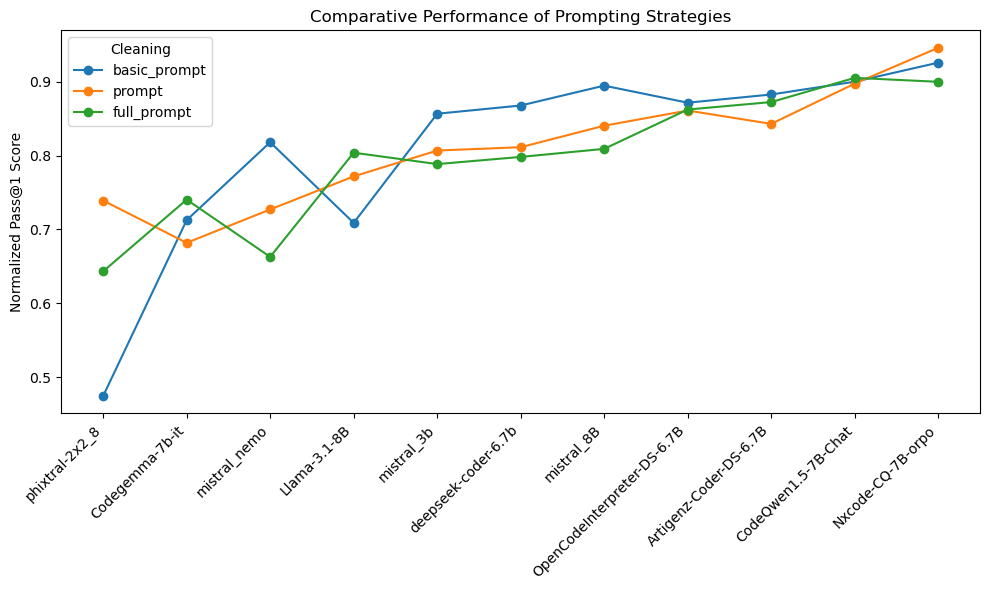

In [15]:
# visualize prompting strategy performance
plot_df = final_prompt_df.sort_values(by='mean')
sorted_models = plot_df.index
plt.figure(figsize=(10, 6))
for col in ['basic_prompt', 'prompt', 'full_prompt']:
    y = plot_df[col]
    plt.plot(range(len(sorted_models)), y, marker='o', label=col)
plt.title('Comparative Performance of Prompting Strategies')
plt.xticks(range(len(sorted_models)), labels=sorted_models, rotation=45, ha='right')
plt.ylabel('Normalized Pass@1 Score')
plt.legend(title='Cleaning')
plt.tight_layout()
plt.show()

In [16]:
# averaging across prompts and datasets
full_cleaned = combined.xs('full', level='cleaning')  # Index: (dataset, prompt), Columns: models

# Step 2: Compute mean score for each (dataset, prompt) pair — across models
mean_by_prompt_dataset = full_cleaned.mean(axis=1).unstack(level='dataset')  # Rows: prompt, Columns: datasets

# Step 3: Add "Mean" column (mean across datasets for each prompt)
mean_by_prompt_dataset['Mean'] = mean_by_prompt_dataset.mean(axis=1)

# Step 4: Reorder rows to ensure correct prompt order
prompt_order = ['basic_prompt', 'prompt', 'full_prompt']
mean_by_prompt_dataset = mean_by_prompt_dataset.loc[prompt_order]
mean_by_prompt_dataset.columns = sheet_names + ['Mean']
mean_by_prompt_dataset.loc['mean'] = mean_by_prompt_dataset.mean(numeric_only=True)

mean_by_prompt_dataset

,HumanEval_Multiagent,BigCode_Multiagent,MBPP_Multiagent,LBPP_Multiagent,Mean
prompt,,,,,
basic_prompt,0.800248,0.882531,0.785380,0.740546,0.802177
prompt,0.852975,0.900872,0.774418,0.696028,0.806073
full_prompt,0.810100,0.898016,0.778205,0.715820,0.800535
mean,0.821108,0.893806,0.779334,0.717465,0.802928


The lower average results for BigCode and LBPP confirm the data leakage (dataset contamination) effect. 

## 2.3 Rank Models on Pre-Agentic Data
__GETTING SLIGHTLY DIFFERENT RESULTS DEPENDING ON WHAT PROMPTING TECHNIQUE I CHOOSE. CONCLUSION - I NEED TO USE AVERAGE ACROSS ALL PROMPTS__

In [17]:
selected_prompt = 'basic_prompt'

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter for the best prompt and cleaning
best_case_df = combined.loc[(slice(None), selected_prompt, 'full_light')]  # Index: (dataset)

# Step 2: Transpose so models are rows, datasets are columns
model_perf_df = best_case_df.T  # Rows = models, Columns = datasets

# Step 3: Add mean column
model_perf_df['mean'] = model_perf_df.mean(axis=1)
model_perf_df = model_perf_df.sort_values(by='mean', ascending=False)

# Optional: reorder columns
#model_perf_df = model_perf_df[['ds1', 'ds2', 'ds3', 'ds4', 'mean']]

# View result
model_perf_df

dataset,HumanEval_Multiagent,BigCode_Multiagent,MBPP_Multiagent,LBPP_Multiagent,mean
Nxcode-CQ-7B-orpo,1.000000,0.968835,0.990757,0.743306,0.925725
CodeQwen1.5-7B-Chat,0.962288,0.924004,0.981910,0.731638,0.899960
mistral_8B,0.925186,0.943522,0.776584,0.933182,0.894619
Artigenz-Coder-DS-6.7B,0.867194,0.858335,0.846016,0.959013,0.882640
OpenCodeInterpreter-DS-6.7B,0.850961,0.805496,0.829602,1.000000,0.871515
deepseek-coder-6.7b,0.855090,0.847105,0.894341,0.874408,0.867736
mistral_3b,0.897636,0.976073,0.720878,0.831765,0.856588
mistral_nemo,0.819555,0.866497,0.726527,0.859498,0.818019
Codegemma-7b-it,0.770203,0.868880,0.649896,0.561303,0.712570
Llama-3.1-8B,0.607122,0.803428,0.609392,0.815392,0.708833


In [18]:
combined.head(25)

phixtral-2x2_8  Llama-3.1-8B  \
dataset              prompt       cleaning                                   
HumanEval_Multiagent basic_prompt raw               0.160487      0.000000   
                                  partial           0.359146      0.585929   
                                  full              0.375512      0.620711   
                                  full_light        0.361436      0.607122   
                     prompt       raw               0.000000      0.000000   
                                  partial           0.661586      0.690944   
                                  full              0.675552      0.847695   
                                  full_light        0.693202      0.862210   
                     full_prompt  raw               0.000000      0.000000   
                                  partial           0.639394      0.652923   
                                  full              0.651784      0.674636   
                                  full_light        0.641607      0.671710   
BigCode_Multiagent   basic_prompt raw               0.199731      0.000000   
                                  partial           0.345657      0.760411   
                                  full              0.616098      0.860975   
                                  full_light        0.443669      0.803428   
                     prompt       raw               0.015544      0.000000   
                                  partial           0.870463      0.664308   
                                  full              0.869496      0.830664   
                                  full_light        0.909620      0.691051   
                     full_prompt  raw               0.024983      0.000000   
                                  partial           0.724849      0.956666   
                                  full              0.870374      0.938487   
                                  full_light        0.777152      0.940187   
MBPP_Multiagent      basic_prompt raw               0.000000      0.000000   

                                              Codegemma-7b-it  \
dataset              prompt       cleaning                      
HumanEval_Multiagent basic_prompt raw                0.000000   
                                  partial            0.651562   
                                  full               0.662949   
                                  full_light         0.770203   
                     prompt       raw                0.000000   
                                  partial            0.584831   
                                  full               0.608990   
                                  full_light         0.605719   
                     full_prompt  raw                0.000000   
                                  partial            0.649964   
                                  full               0.662625   
                                  full_light         0.638706   
BigCode_Multiagent   basic_prompt raw                0.000000   
                                  partial            0.851744   
                                  full               0.893251   
                                  full_light         0.868880   
                     prompt       raw                0.000000   
                                  partial            0.886218   
                                  full               0.936929   
                                  full_light         0.893306   
                     full_prompt  raw                0.000000   
                                  partial            0.968348   
                                  full               0.925577   
                                  full_light         0.972340   
MBPP_Multiagent      basic_prompt raw                0.000000   

                                              deepseek-coder-6.7b  \
dataset              prompt       cleaning                          
HumanEval_Multiagent basic_prompt raw        

In [19]:
best_case_df

,phixtral-2x2_8,Llama-3.1-8B,Codegemma-7b-it,deepseek-coder-6.7b,OpenCodeInterpreter-DS-6.7B,Artigenz-Coder-DS-6.7B,CodeQwen1.5-7B-Chat,Nxcode-CQ-7B-orpo,mistral_3b,mistral_8B,mistral_nemo
dataset,,,,,,,,,,,
HumanEval_Multiagent,0.361436,0.607122,0.770203,0.855090,0.850961,0.867194,0.962288,1.000000,0.897636,0.925186,0.819555
BigCode_Multiagent,0.443669,0.803428,0.868880,0.847105,0.805496,0.858335,0.924004,0.968835,0.976073,0.943522,0.866497
MBPP_Multiagent,0.577917,0.609392,0.649896,0.894341,0.829602,0.846016,0.981910,0.990757,0.720878,0.776584,0.726527
LBPP_Multiagent,0.515223,0.815392,0.561303,0.874408,1.000000,0.959013,0.731638,0.743306,0.831765,0.933182,0.859498


## Average across all prompts
This gives me the same results as in the above cell that says this at the top: SAME CODE AS IN THE PREVIOUS CELL, BUT CURTAILED TO RANK THE MODEL BY AVERAGE ACROSS ALL PROMPTS

In [20]:
# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter for cleaning == 'full' only
full_cleaned = combined.xs('full_light', level='cleaning')

# Step 2: Average across all prompts within each dataset
avg_by_dataset = full_cleaned.groupby('dataset').mean()

# Step 3: Transpose so models are rows, datasets are columns
model_perf_df = avg_by_dataset.T  # Rows = models, Columns = datasets

# Step 4: Add mean column
model_perf_df['mean'] = model_perf_df.mean(axis=1)
model_perf_df = model_perf_df.sort_values(by='mean', ascending=False)
model_perf_df.loc['mean'] = model_perf_df.mean()

# View result
model_perf_df

dataset,BigCode_Multiagent,HumanEval_Multiagent,LBPP_Multiagent,MBPP_Multiagent,mean
Nxcode-CQ-7B-orpo,0.943383,0.982443,0.792998,0.976428,0.923813
CodeQwen1.5-7B-Chat,0.928602,0.981720,0.732175,0.960809,0.900826
Artigenz-Coder-DS-6.7B,0.864354,0.883363,0.887219,0.828980,0.865979
OpenCodeInterpreter-DS-6.7B,0.875232,0.870060,0.879713,0.834628,0.864908
mistral_8B,0.921520,0.902369,0.804913,0.763270,0.848018
deepseek-coder-6.7b,0.852550,0.883937,0.763021,0.803358,0.825716
mistral_3b,0.950525,0.888856,0.731689,0.698016,0.817272
Llama-3.1-8B,0.811555,0.713681,0.831107,0.689585,0.761482
mistral_nemo,0.679504,0.754806,0.792930,0.716596,0.735959
Codegemma-7b-it,0.911509,0.671543,0.588351,0.674972,0.711593


In [21]:
0.805707 - 0.748568

0.05713899999999994

In [22]:
0.806774 - 0.748568


0.05820599999999998

# PART 3. Select Best Cleaning Method, Best Prompting Strategy, and Rank SLMs Using Mean Values

## 3.1 Select the best cleaning method

### 3.1.1 Approach 1

In [23]:
# get mean values for each cleaning method and compare them with raw - the method with the largest diff wins
for key in res:
    df = res[key].copy()
    mean_scores = df.mean(axis=1).unstack(level=1)
    mean_scores.loc['mean'] = mean_scores.max()
    max_col = mean_scores.loc['mean'].idxmax()
    print(f'Dataset: {key}\n')
    print(f"Cleaning method with the highest mean score: {max_col}")
    
    # Difference with raw
    full_value = mean_scores.loc['mean', 'full']
    full_light = mean_scores.loc['mean', 'full_light']
    raw_value  = mean_scores.loc['mean', 'raw']
    print(f"Difference between full and raw:       {full_value - raw_value:.5f}")
    print(f"Difference between full_light and raw: {full_light - raw_value:.5f}")
    print(f"Overall difference:                    {(full_value - raw_value)-(full_light-raw_value):.5f}\n")
    print(mean_scores)
    print('\n', '='*77, '\n', sep='')

Dataset: HumanEval_Multiagent

Cleaning method with the highest mean score: full_light
Difference between full and raw:       0.73732
Difference between full_light and raw: 0.75000
Overall difference:                    -0.01268

cleaning          full  full_light   partial       raw
prompt                                                
basic_prompt  0.800248    0.810606  0.797416  0.115658
full_prompt   0.810100    0.805062  0.744452  0.019499
prompt        0.852975    0.865657  0.747296  0.017577
mean          0.852975    0.865657  0.797416  0.115658


Dataset: BigCode_Multiagent

Cleaning method with the highest mean score: full
Difference between full and raw:       0.78358
Difference between full_light and raw: 0.77087
Overall difference:                    0.01270

cleaning          full  full_light   partial       raw
prompt                                                
basic_prompt  0.882531    0.845986  0.824644  0.117296
full_prompt   0.898016    0.888169  0.860890  0.0064

In [24]:
full = (0.47053+0.62294+0.76505+0.70694)
full_light = (0.47246+0.59140+0.76216+0.73611)
print(f'Full cleaning:       {full}\nFull light cleaning: {full_light}')

Full cleaning:       2.56546
Full light cleaning: 2.56213


__The full cleaning method wins__ because it has the largest overall difference with the raw cleaning results across all the prompts and all the datasets, but the difference is minimal.

### 3.1.2 Approach 2

In [25]:
# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Average across prompts for each (dataset, cleaning, model)
avg_across_prompts = combined.groupby(['dataset', 'cleaning']).max()

# Step 2: Average across datasets for each (cleaning, model)
avg_across_all = avg_across_prompts.groupby('cleaning').mean()

# Step 3: Transpose to get models as rows
final_df = avg_across_all.T

# Step 4: sort columns if needed
cleaning_order = ['raw', 'partial', 'full', 'full_light']
final_df = final_df[cleaning_order]
final_df['best_cleaning'] = final_df.idxmax(axis=1)
final_df['best_cleaning2'] = final_df[cleaning_order].idxmax(axis=1).map({name: i for i, name in enumerate(cleaning_order)})
final_df = final_df.sort_values(by='full')
final_df.loc['mean'] = final_df.mean(numeric_only=True)

print(final_df['best_cleaning'].value_counts())
final_df

best_cleaning
full_light    9
partial       1
full          1
Name: count, dtype: int64


cleaning,raw,partial,full,full_light,best_cleaning,best_cleaning2
phixtral-2x2_8,0.119431,0.685764,0.698115,0.739030,full_light,3.000000
Codegemma-7b-it,0.000000,0.711861,0.729092,0.777473,full_light,3.000000
mistral_nemo,0.000000,0.817579,0.816649,0.820880,full_light,3.000000
mistral_3b,0.000000,0.855396,0.837165,0.856588,full_light,3.000000
Llama-3.1-8B,0.000000,0.823734,0.857169,0.881333,full_light,3.000000
deepseek-coder-6.7b,0.050545,0.884063,0.866877,0.923661,full_light,3.000000
mistral_8B,0.000000,0.905704,0.875407,0.899465,partial,1.000000
Artigenz-Coder-DS-6.7B,0.326168,0.897812,0.906768,0.920144,full_light,3.000000
OpenCodeInterpreter-DS-6.7B,0.215811,0.905404,0.914194,0.922813,full_light,3.000000
Nxcode-CQ-7B-orpo,0.000000,0.911846,0.948243,0.963169,full_light,3.000000


__Partial wins when aggregating by max() both time__.  
__Full wins when doing max() first time and mean() the second gtime in the code above__

In [26]:
# sanity check - view all intermediate dataframes used above
avg_across_prompts.head(25)

phixtral-2x2_8  Llama-3.1-8B  \
dataset              cleaning                                   
BigCode_Multiagent   full              0.870374      0.938487   
                     full_light        0.909620      0.940187   
                     partial           0.870463      0.956666   
                     raw               0.199731      0.000000   
HumanEval_Multiagent full              0.675552      0.847695   
                     full_light        0.693202      0.862210   
                     partial           0.661586      0.690944   
                     raw               0.160487      0.000000   
LBPP_Multiagent      full              0.567215      0.793785   
                     full_light        0.692629      0.898666   
                     partial           0.554869      0.881448   
                     raw               0.083149      0.000000   
MBPP_Multiagent      full              0.679320      0.848708   
                     full_light        0.660668      0.824270   
                     partial           0.656138      0.765878   
                     raw               0.034356      0.000000   

                                 Codegemma-7b-it  deepseek-coder-6.7b  \
dataset              cleaning                                           
BigCode_Multiagent   full               0.936929             0.915310   
                     full_light         0.972340             0.950688   
                     partial            0.968348             0.979611   
                     raw                0.000000             0.066585   
HumanEval_Multiagent full               0.662949             0.921267   
                     full_light         0.770203             0.975208   
                     partial            0.651562             0.939131   
                     raw                0.000000             0.135596   
LBPP_Multiagent      full               0.640521             0.822841   
                     full_light         0.671317             0.874408   
                     partial            0.551806             0.804325   
                     raw                0.000000             0.000000   
MBPP_Multiagent      full               0.675971             0.808089   
                     full_light         0.696034             0.894341   
                     partial            0.675728             0.813184   
                     raw                0.000000             0.000000   

                                 OpenCodeInterpreter-DS-6.7B  \
dataset              cleaning                                  
BigCode_Multiagent   full                           0.982817   
                     full_light                     0.953606   
                     partial                        0.958254   
                     raw                            0.306061   
HumanEval_Multiagent full                           0.875691   
                     full_light                     0.885275   
                     partial                        0.920123   
                     raw                            0.416657   
LBPP_Multiagent      full                           0.945285   
                     full_light                     1.000000   
                     partial                        0.908652   
                     raw                            0.030633   
MBPP_Multiagent      full                           0.852983   
                     full_light                     0.852373   
                     partial                        0.834588   
                     raw                            0.109893   

                                 Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  \
dataset              cleaning                                                  
BigCode_Multiagent   full                      0.984235             0.972880   
                     full_light                0.942332             0.935425   
                     partial                   0.931630             0.9730

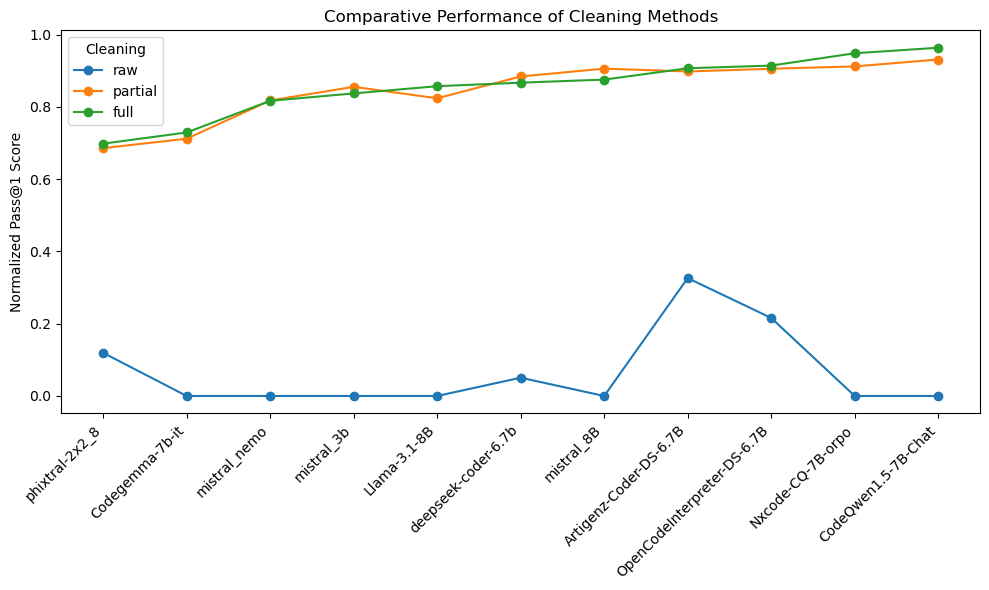

In [27]:
# visualize cleaning method performance
plot_df = final_df.drop(index='mean')
sorted_models = plot_df.index 
plt.figure(figsize=(10, 6))
for col in ['raw', 'partial', 'full']:
    y = plot_df[col]
    plt.plot(range(len(sorted_models)), y, marker='o', label=col)
plt.title('Comparative Performance of Cleaning Methods')
plt.xticks(range(len(sorted_models)), labels=sorted_models, rotation=45, ha='right')
plt.ylabel('Normalized Pass@1 Score')
plt.legend(title='Cleaning')
plt.tight_layout()
plt.show()

## 3.2 Select the best prompting strategy

In [28]:
# SELECT THE BEST PROMPTING STRATEGY

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter combined by the best cleaning method == 'full'
full_cleaned = combined.xs('full', level='cleaning')

# Step 2: Average across datasets for each prompt and model
avg_by_prompt = full_cleaned.groupby('prompt').max()

# Step 3: Transpose so rows = models, columns = prompts
final_prompt_df = avg_by_prompt.T

# Step 4: Reorder prompt columns if needed
prompt_order    = ['basic_prompt', 'prompt', 'full_prompt']
final_prompt_df = final_prompt_df[prompt_order]
final_prompt_df['best_prompt'] = final_prompt_df.idxmax(axis=1)
final_prompt_df['best_prompt2'] = final_prompt_df[prompt_order].idxmax(axis=1).map({name: i for i, name in enumerate(prompt_order)})
final_prompt_df = final_prompt_df.sort_values(by='basic_prompt')
final_prompt_df.loc['mean']       = final_prompt_df.mean(numeric_only=True)

print(final_prompt_df['best_prompt'].value_counts())
final_prompt_df

best_prompt
full_prompt     5
prompt          3
basic_prompt    3
Name: count, dtype: int64


prompt,basic_prompt,prompt,full_prompt,best_prompt,best_prompt2
phixtral-2x2_8,0.616098,0.869496,0.870374,full_prompt,2.000000
Llama-3.1-8B,0.860975,0.847695,0.938487,full_prompt,2.000000
Codegemma-7b-it,0.893251,0.936929,0.925577,prompt,1.000000
Artigenz-Coder-DS-6.7B,0.897558,0.864362,0.984235,full_prompt,2.000000
mistral_nemo,0.904780,0.834215,0.720712,basic_prompt,0.000000
deepseek-coder-6.7b,0.915310,0.921267,0.899444,prompt,1.000000
mistral_3b,0.927304,0.905931,0.955745,full_prompt,2.000000
OpenCodeInterpreter-DS-6.7B,0.945285,0.938385,0.982817,full_prompt,2.000000
mistral_8B,0.977162,0.969200,0.945553,basic_prompt,0.000000
Nxcode-CQ-7B-orpo,0.986096,0.985912,0.977316,basic_prompt,0.000000


In [29]:
# SAME CODE AS IN THE PREVIOUS CELL, BUT CURTAILED TO RANK THE MODEL BY AVERAGE ACROSS ALL PROMPTS

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter combined by the best cleaning method == 'full'
full_cleaned = combined.xs('full', level='cleaning')

# Step 2: Average across datasets for each prompt and model
avg_by_prompt = full_cleaned.groupby('prompt').max()

# Step 3: Transpose so rows = models, columns = prompts
final_prompt_df = avg_by_prompt.T

# Step 4: Reorder prompt columns if needed
prompt_order    = ['basic_prompt', 'prompt', 'full_prompt']
final_prompt_df = final_prompt_df[prompt_order]

final_prompt_df['mean'] = final_prompt_df.mean(axis=1)
final_prompt_df = final_prompt_df.sort_values(by='mean', ascending=False)

final_prompt_df

prompt,basic_prompt,prompt,full_prompt,mean
CodeQwen1.5-7B-Chat,0.992521,0.993170,0.983944,0.989878
Nxcode-CQ-7B-orpo,0.986096,0.985912,0.977316,0.983108
mistral_8B,0.977162,0.969200,0.945553,0.963971
OpenCodeInterpreter-DS-6.7B,0.945285,0.938385,0.982817,0.955496
mistral_3b,0.927304,0.905931,0.955745,0.929660
Codegemma-7b-it,0.893251,0.936929,0.925577,0.918586
Artigenz-Coder-DS-6.7B,0.897558,0.864362,0.984235,0.915385
deepseek-coder-6.7b,0.915310,0.921267,0.899444,0.912007
Llama-3.1-8B,0.860975,0.847695,0.938487,0.882386
mistral_nemo,0.904780,0.834215,0.720712,0.819903


In [30]:
combined.head(25)

phixtral-2x2_8  Llama-3.1-8B  \
dataset              prompt       cleaning                                   
HumanEval_Multiagent basic_prompt raw               0.160487      0.000000   
                                  partial           0.359146      0.585929   
                                  full              0.375512      0.620711   
                                  full_light        0.361436      0.607122   
                     prompt       raw               0.000000      0.000000   
                                  partial           0.661586      0.690944   
                                  full              0.675552      0.847695   
                                  full_light        0.693202      0.862210   
                     full_prompt  raw               0.000000      0.000000   
                                  partial           0.639394      0.652923   
                                  full              0.651784      0.674636   
                                  full_light        0.641607      0.671710   
BigCode_Multiagent   basic_prompt raw               0.199731      0.000000   
                                  partial           0.345657      0.760411   
                                  full              0.616098      0.860975   
                                  full_light        0.443669      0.803428   
                     prompt       raw               0.015544      0.000000   
                                  partial           0.870463      0.664308   
                                  full              0.869496      0.830664   
                                  full_light        0.909620      0.691051   
                     full_prompt  raw               0.024983      0.000000   
                                  partial           0.724849      0.956666   
                                  full              0.870374      0.938487   
                                  full_light        0.777152      0.940187   
MBPP_Multiagent      basic_prompt raw               0.000000      0.000000   

                                              Codegemma-7b-it  \
dataset              prompt       cleaning                      
HumanEval_Multiagent basic_prompt raw                0.000000   
                                  partial            0.651562   
                                  full               0.662949   
                                  full_light         0.770203   
                     prompt       raw                0.000000   
                                  partial            0.584831   
                                  full               0.608990   
                                  full_light         0.605719   
                     full_prompt  raw                0.000000   
                                  partial            0.649964   
                                  full               0.662625   
                                  full_light         0.638706   
BigCode_Multiagent   basic_prompt raw                0.000000   
                                  partial            0.851744   
                                  full               0.893251   
                                  full_light         0.868880   
                     prompt       raw                0.000000   
                                  partial            0.886218   
                                  full               0.936929   
                                  full_light         0.893306   
                     full_prompt  raw                0.000000   
                                  partial            0.968348   
                                  full               0.925577   
                                  full_light         0.972340   
MBPP_Multiagent      basic_prompt raw                0.000000   

                                              deepseek-coder-6.7b  \
dataset              prompt       cleaning                          
HumanEval_Multiagent basic_prompt raw        

In [31]:
# sanity check - view intermediate dataframes used in the above code
full_cleaned.head(25)

phixtral-2x2_8  Llama-3.1-8B  \
dataset              prompt                                       
HumanEval_Multiagent basic_prompt        0.375512      0.620711   
                     prompt              0.675552      0.847695   
                     full_prompt         0.651784      0.674636   
BigCode_Multiagent   basic_prompt        0.616098      0.860975   
                     prompt              0.869496      0.830664   
                     full_prompt         0.870374      0.938487   
MBPP_Multiagent      basic_prompt        0.583935      0.593185   
                     prompt              0.679320      0.641364   
                     full_prompt         0.638716      0.848708   
LBPP_Multiagent      basic_prompt        0.432076      0.793785   
                     prompt              0.567215      0.765755   
                     full_prompt         0.474410      0.720647   

                                   Codegemma-7b-it  deepseek-coder-6.7b  \
dataset              prompt                                               
HumanEval_Multiagent basic_prompt         0.662949             0.840908   
                     prompt               0.608990             0.921267   
                     full_prompt          0.662625             0.845571   
BigCode_Multiagent   basic_prompt         0.893251             0.915310   
                     prompt               0.936929             0.893605   
                     full_prompt          0.925577             0.899444   
MBPP_Multiagent      basic_prompt         0.668430             0.808089   
                     prompt               0.653880             0.760486   
                     full_prompt          0.675971             0.734583   
LBPP_Multiagent      basic_prompt         0.524116             0.822841   
                     prompt               0.443616             0.695556   
                     full_prompt          0.640521             0.679715   

                                   OpenCodeInterpreter-DS-6.7B  \
dataset              prompt                                      
HumanEval_Multiagent basic_prompt                     0.845139   
                     prompt                           0.867085   
                     full_prompt                      0.875691   
BigCode_Multiagent   basic_prompt                     0.857887   
                     prompt                           0.938385   
                     full_prompt                      0.982817   
MBPP_Multiagent      basic_prompt                     0.828439   
                     prompt                           0.852983   
                     full_prompt                      0.801859   
LBPP_Multiagent      basic_prompt                     0.945285   
                     prompt                           0.828768   
                     full_prompt                      0.828432   

                                   Artigenz-Coder-DS-6.7B  \
dataset              prompt                                 
HumanEval_Multiagent basic_prompt                0.897558   
                     prompt                      0.857049   
                     full_prompt                 0.831672   
BigCode_Multiagent   basic_prompt                0.868861   
                     prompt                      0.864362   
                     full_prompt                 0.984235   
MBPP_Multiagent      basic_prompt                0.875690   
                     prompt                      0.828929   
                     full_prompt                 0.841678   
LBPP_Multiagent      basic_prompt                0.869590   
                     prompt                      0.800129   
                     full_prompt                 0.816188   

                                   CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  \
dataset              prompt                                                 
HumanEval_Multiagent basic_prompt             0.972858           0.986096   
                     prompt       

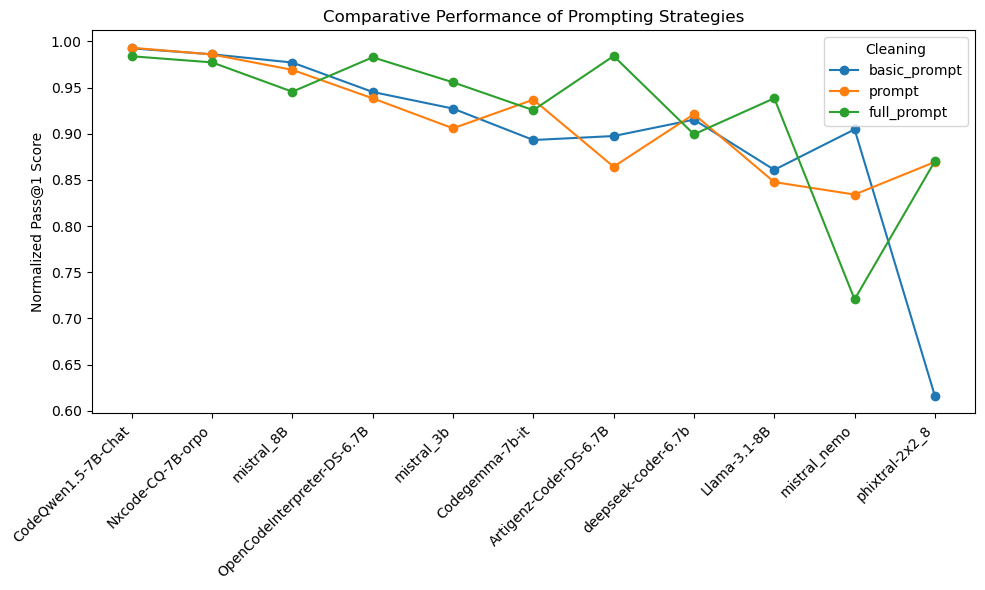

In [32]:
# visualize prompting strategy performance
plot_df = final_prompt_df
sorted_models = plot_df.index
plt.figure(figsize=(10, 6))
for col in ['basic_prompt', 'prompt', 'full_prompt']:
    y = plot_df[col]
    plt.plot(range(len(sorted_models)), y, marker='o', label=col)
plt.title('Comparative Performance of Prompting Strategies')
plt.xticks(range(len(sorted_models)), labels=sorted_models, rotation=45, ha='right')
plt.ylabel('Normalized Pass@1 Score')
plt.legend(title='Cleaning')
plt.tight_layout()
plt.show()

In [33]:
# averaging across prompts and datasets
full_cleaned = combined.xs('full', level='cleaning')  # Index: (dataset, prompt), Columns: models

# Step 2: Compute mean score for each (dataset, prompt) pair — across models
mean_by_prompt_dataset = full_cleaned.mean(axis=1).unstack(level='dataset')  # Rows: prompt, Columns: datasets

# Step 3: Add "Mean" column (mean across datasets for each prompt)
mean_by_prompt_dataset['Mean'] = mean_by_prompt_dataset.max(axis=1)

# Step 4: Reorder rows to ensure correct prompt order
prompt_order = ['basic_prompt', 'prompt', 'full_prompt']
mean_by_prompt_dataset = mean_by_prompt_dataset.loc[prompt_order]
mean_by_prompt_dataset.columns = sheet_names + ['Mean']
mean_by_prompt_dataset.loc['mean'] = mean_by_prompt_dataset.mean(numeric_only=True)

mean_by_prompt_dataset

,HumanEval_Multiagent,BigCode_Multiagent,MBPP_Multiagent,LBPP_Multiagent,Mean
prompt,,,,,
basic_prompt,0.800248,0.882531,0.785380,0.740546,0.882531
prompt,0.852975,0.900872,0.774418,0.696028,0.900872
full_prompt,0.810100,0.898016,0.778205,0.715820,0.898016
mean,0.821108,0.893806,0.779334,0.717465,0.893806


The lower average results for BigCode and LBPP confirm the data leakage (dataset contamination) effect. 

## 3.3 Rank Models on Pre-Agentic Data
__GETTING SLIGHTLY DIFFERENT RESULTS DEPENDING ON WHAT PROMPTING TECHNIQUE I CHOOSE. CONCLUSION - I NEED TO USE AVERAGE ACROSS ALL PROMPTS__

In [34]:
selected_prompt = 'basic_prompt'

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter for the best prompt and cleaning
best_case_df = combined.loc[(slice(None), selected_prompt, 'full')]  # Index: (dataset)

# Step 2: Transpose so models are rows, datasets are columns
model_perf_df = best_case_df.T  # Rows = models, Columns = datasets

# Step 3: Add mean column
model_perf_df['mean'] = model_perf_df.max(axis=1)
model_perf_df = model_perf_df.sort_values(by='mean', ascending=False)

# Optional: reorder columns
#model_perf_df = model_perf_df[['ds1', 'ds2', 'ds3', 'ds4', 'mean']]

# View result
model_perf_df

dataset,HumanEval_Multiagent,BigCode_Multiagent,MBPP_Multiagent,LBPP_Multiagent,mean
CodeQwen1.5-7B-Chat,0.972858,0.972880,0.992521,0.729010,0.992521
Nxcode-CQ-7B-orpo,0.986096,0.913334,0.977755,0.734387,0.986096
mistral_8B,0.908621,0.977162,0.829404,0.741654,0.977162
OpenCodeInterpreter-DS-6.7B,0.845139,0.857887,0.828439,0.945285,0.945285
mistral_3b,0.878582,0.927304,0.757814,0.729169,0.927304
deepseek-coder-6.7b,0.840908,0.915310,0.808089,0.822841,0.915310
mistral_nemo,0.813799,0.904780,0.723918,0.824099,0.904780
Artigenz-Coder-DS-6.7B,0.897558,0.868861,0.875690,0.869590,0.897558
Codegemma-7b-it,0.662949,0.893251,0.668430,0.524116,0.893251
Llama-3.1-8B,0.620711,0.860975,0.593185,0.793785,0.860975


In [35]:
combined.head(25)

phixtral-2x2_8  Llama-3.1-8B  \
dataset              prompt       cleaning                                   
HumanEval_Multiagent basic_prompt raw               0.160487      0.000000   
                                  partial           0.359146      0.585929   
                                  full              0.375512      0.620711   
                                  full_light        0.361436      0.607122   
                     prompt       raw               0.000000      0.000000   
                                  partial           0.661586      0.690944   
                                  full              0.675552      0.847695   
                                  full_light        0.693202      0.862210   
                     full_prompt  raw               0.000000      0.000000   
                                  partial           0.639394      0.652923   
                                  full              0.651784      0.674636   
                                  full_light        0.641607      0.671710   
BigCode_Multiagent   basic_prompt raw               0.199731      0.000000   
                                  partial           0.345657      0.760411   
                                  full              0.616098      0.860975   
                                  full_light        0.443669      0.803428   
                     prompt       raw               0.015544      0.000000   
                                  partial           0.870463      0.664308   
                                  full              0.869496      0.830664   
                                  full_light        0.909620      0.691051   
                     full_prompt  raw               0.024983      0.000000   
                                  partial           0.724849      0.956666   
                                  full              0.870374      0.938487   
                                  full_light        0.777152      0.940187   
MBPP_Multiagent      basic_prompt raw               0.000000      0.000000   

                                              Codegemma-7b-it  \
dataset              prompt       cleaning                      
HumanEval_Multiagent basic_prompt raw                0.000000   
                                  partial            0.651562   
                                  full               0.662949   
                                  full_light         0.770203   
                     prompt       raw                0.000000   
                                  partial            0.584831   
                                  full               0.608990   
                                  full_light         0.605719   
                     full_prompt  raw                0.000000   
                                  partial            0.649964   
                                  full               0.662625   
                                  full_light         0.638706   
BigCode_Multiagent   basic_prompt raw                0.000000   
                                  partial            0.851744   
                                  full               0.893251   
                                  full_light         0.868880   
                     prompt       raw                0.000000   
                                  partial            0.886218   
                                  full               0.936929   
                                  full_light         0.893306   
                     full_prompt  raw                0.000000   
                                  partial            0.968348   
                                  full               0.925577   
                                  full_light         0.972340   
MBPP_Multiagent      basic_prompt raw                0.000000   

                                              deepseek-coder-6.7b  \
dataset              prompt       cleaning                          
HumanEval_Multiagent basic_prompt raw        

In [36]:
best_case_df

,phixtral-2x2_8,Llama-3.1-8B,Codegemma-7b-it,deepseek-coder-6.7b,OpenCodeInterpreter-DS-6.7B,Artigenz-Coder-DS-6.7B,CodeQwen1.5-7B-Chat,Nxcode-CQ-7B-orpo,mistral_3b,mistral_8B,mistral_nemo
dataset,,,,,,,,,,,
HumanEval_Multiagent,0.375512,0.620711,0.662949,0.840908,0.845139,0.897558,0.972858,0.986096,0.878582,0.908621,0.813799
BigCode_Multiagent,0.616098,0.860975,0.893251,0.915310,0.857887,0.868861,0.972880,0.913334,0.927304,0.977162,0.904780
MBPP_Multiagent,0.583935,0.593185,0.668430,0.808089,0.828439,0.875690,0.992521,0.977755,0.757814,0.829404,0.723918
LBPP_Multiagent,0.432076,0.793785,0.524116,0.822841,0.945285,0.869590,0.729010,0.734387,0.729169,0.741654,0.824099


## Get Max Across All Prompts
This gives me the same results as in the above cell that says this at the top: SAME CODE AS IN THE PREVIOUS CELL, BUT CURTAILED TO RANK THE MODEL BY AVERAGE ACROSS ALL PROMPTS

In [38]:
# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter for cleaning == 'full' only
full_cleaned = combined.xs('full', level='cleaning')

# Step 2: Average across all prompts within each dataset
avg_by_dataset = full_cleaned.groupby('dataset').max()

# Step 3: Transpose so models are rows, datasets are columns
model_perf_df = avg_by_dataset.T  # Rows = models, Columns = datasets

# Step 4: Add mean column
model_perf_df['Max'] = model_perf_df.max(axis=1)
model_perf_df = model_perf_df.sort_values(by='Max', ascending=False)
model_perf_df.loc['mean'] = model_perf_df.mean()

# View result
model_perf_df

dataset,BigCode_Multiagent,HumanEval_Multiagent,LBPP_Multiagent,MBPP_Multiagent,Max
CodeQwen1.5-7B-Chat,0.972880,0.993170,0.895523,0.992521,0.993170
Nxcode-CQ-7B-orpo,0.941284,0.986096,0.879681,0.985912,0.986096
Artigenz-Coder-DS-6.7B,0.984235,0.897558,0.869590,0.875690,0.984235
OpenCodeInterpreter-DS-6.7B,0.982817,0.875691,0.945285,0.852983,0.982817
mistral_8B,0.977162,0.950401,0.744663,0.829404,0.977162
mistral_3b,0.955745,0.905931,0.729169,0.757814,0.955745
Llama-3.1-8B,0.938487,0.847695,0.793785,0.848708,0.938487
Codegemma-7b-it,0.936929,0.662949,0.640521,0.675971,0.936929
deepseek-coder-6.7b,0.915310,0.921267,0.822841,0.808089,0.921267
mistral_nemo,0.904780,0.813799,0.824099,0.723918,0.904780
